# Quantum Chemistry for Simulating Hydrides                                                                  
• Simulated the properties of molecules and chemical reactions

• Studied the applications and differences of several simulating approaches

• Optimized the measuring process, making it 4 times more efficient  


## _*NaH dissociation curve using VQE with UCCSD*_

This notebook demonstrates using the Qiskit Chemistry to plot graphs of the ground state energy of the Sodium Hydride (NaH) molecule over a range of inter-atomic distances using VQE and UCCSD. It is compared to the same energies as computed by the NumPyMinimumEigensolver.

_*Note: this molecule is larger than the similar LiH and this notebook can take a while to run.*_

This notebook has been written to use the PYSCF chemistry driver.

In [1]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

molecule = 'H .0 .0 -{0}; Na .0 .0 {0}'
algorithms = ['VQE', 'NumPyMinimumEigensolver']

pts  = [x * 0.1  for x in range(10, 25)]
pts += [x * 0.25 for x in range(10, 18)]
pts += [4.5]
energies = np.empty([len(algorithms), len(pts)])
hf_energies = np.empty(len(pts))
distances = np.empty(len(pts))
dipoles     = np.empty([len(algorithms), len(pts)])
eval_counts = np.empty(len(pts))

print('Processing step __', end='')
for i, d in enumerate(pts):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    for j in range(len(algorithms)):
        driver = PySCFDriver(atom=molecule.format(d/2), basis='sto3g')
        qmolecule = driver.run()
        operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                                two_qubit_reduction=True,
                                freeze_core=True, orbital_reduction=[])
        qubit_op, aux_ops = operator.run(qmolecule)
        if algorithms[j] == 'NumPyMinimumEigensolver':
            result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
        else:
            optimizer = SLSQP(maxiter=2500)
            initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                                        operator.molecule_info['num_particles'],
                                        qubit_mapping=operator._qubit_mapping,
                                        two_qubit_reduction=operator._two_qubit_reduction)
            var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                            num_particles=operator.molecule_info['num_particles'],
                            initial_state=initial_state,
                            qubit_mapping=operator._qubit_mapping,
                            two_qubit_reduction=operator._two_qubit_reduction)
            algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
            result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
            eval_counts[i] = result.optimizer_evals
                              
        result = operator.process_algorithm_result(result)
        energies[j][i] = result.energy
        hf_energies[i] = result.hartree_fock_energy
        dipoles[j][i]  = result.total_dipole_moment / 0.393430307

    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('Dipoles:', dipoles)
print('VQE num evaluations:', eval_counts)


Processing step 23 --- complete
Distances:  [1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3
 2.4  2.5  2.75 3.   3.25 3.5  3.75 4.   4.25 4.5 ]
Energies: [[-160.05849063 -160.15699836 -160.22568735 -160.27202139 -160.30172252
  -160.31895083 -160.32675432 -160.32741528 -160.32269878 -160.31400273
  -160.30245852 -160.28899051 -160.27435538 -160.2591661  -160.2439109
  -160.22897181 -160.19475711 -160.16708758 -160.14746338 -160.13627128
  -160.13114984 -160.12788151 -160.12587996 -160.06078205]
 [-160.05849084 -160.15699856 -160.22568741 -160.2720216  -160.30172261
  -160.31895199 -160.32675458 -160.32741545 -160.32269886 -160.31400297
  -160.30245861 -160.28899063 -160.27435552 -160.25916618 -160.24391112
  -160.22897222 -160.19475719 -160.16708762 -160.14746354 -160.13627173
  -160.13150727 -160.12988489 -160.12941537 -160.12738873]]
Hartree-Fock energies: [-160.04320295 -160.14360744 -160.21336733 -160.26022033 -160.29007462
 -160.30721237 -160.31476208 -160.31

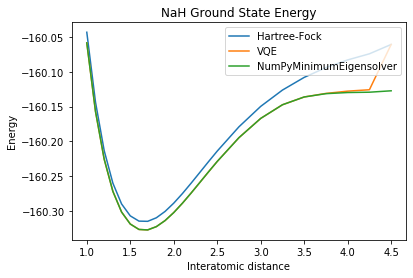

In [2]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('NaH Ground State Energy')
pylab.legend(loc='upper right');

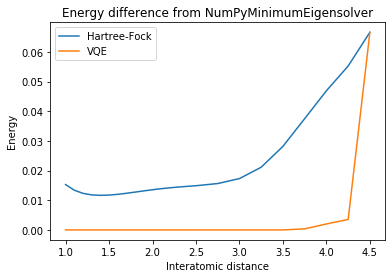

In [3]:
pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label='VQE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from NumPyMinimumEigensolver')
pylab.legend(loc='upper left');

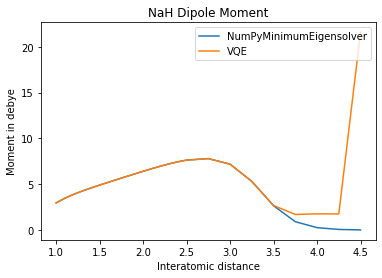

In [4]:
for j in reversed(range(len(algorithms))):
    pylab.plot(distances, dipoles[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Moment in debye')
pylab.title('NaH Dipole Moment')
pylab.legend(loc='upper right');

## _*LiH dissociation curve using VQE with UCCSD variational form*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Lithium Hydride (LiH) molecule over a range of inter-atomic distances using VQE and UCCSD. It is compared to the same energies as computed by the NumPyMinimumEigensolver

This notebook has been written to use the PYSCF chemistry driver.

In [1]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
algorithms = ['VQE', 'NumPyMinimumEigensolver']

pts  = [x * 0.1  for x in range(6, 20)]
pts += [x * 0.25 for x in range(8, 16)]
pts += [4.0]
energies = np.empty([len(algorithms), len(pts)])
hf_energies = np.empty(len(pts))
distances = np.empty(len(pts))
dipoles     = np.empty([len(algorithms), len(pts)])
eval_counts = np.empty(len(pts))

print('Processing step __', end='')
for i, d in enumerate(pts):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    for j in range(len(algorithms)):   
        driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
        qmolecule = driver.run()
        operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                                two_qubit_reduction=True, freeze_core=True,
                                orbital_reduction=[-3, -2])
        qubit_op, aux_ops = operator.run(qmolecule)
        if algorithms[j] == 'NumPyMinimumEigensolver':
            result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
        else:
            optimizer = SLSQP(maxiter=1000)
            initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                                        operator.molecule_info['num_particles'],
                                        qubit_mapping=operator._qubit_mapping,
                                        two_qubit_reduction=operator._two_qubit_reduction)
            var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                            num_particles=operator.molecule_info['num_particles'],
                            initial_state=initial_state,
                            qubit_mapping=operator._qubit_mapping,
                            two_qubit_reduction=operator._two_qubit_reduction)
            algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
            result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
            eval_counts[i] = result.optimizer_evals
            
        result = operator.process_algorithm_result(result)
        energies[j][i] = result.energy
        hf_energies[i] = result.hartree_fock_energy
        dipoles[j][i]  = result.total_dipole_moment / 0.393430307

    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)

Processing step 22 --- complete
Distances:  [0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.  ]
Energies: [[-7.3133458  -7.50092206 -7.63097823 -7.7208124  -7.78224239 -7.82359927
  -7.85069837 -7.86756328 -7.87700148 -7.8810157  -7.88107203 -7.87826815
  -7.87344011 -7.86723367 -7.86015319 -7.84104235 -7.82307636 -7.80861236
  -7.79836328 -7.79175303 -7.78771683 -7.7853196  -7.78391829]
 [-7.31334583 -7.50092209 -7.63097825 -7.72081241 -7.7822424  -7.82359928
  -7.85069838 -7.86756329 -7.87700149 -7.88101572 -7.88107204 -7.87826817
  -7.87344029 -7.86723396 -7.86015321 -7.84104271 -7.82307664 -7.8086124
  -7.79836343 -7.79175325 -7.78771697 -7.78531972 -7.78391847]]
Hartree-Fock energies: [-7.29954105 -7.48594487 -7.61577016 -7.70575334 -7.76736214 -7.80874318
 -7.83561583 -7.85195386 -7.86053866 -7.86335762 -7.86186477 -7.85714496
 -7.8500187  -7.84111204 -7.83090558 -7.80193896 -7.77087367 -7.74000074
 -7.7108299  -7.6

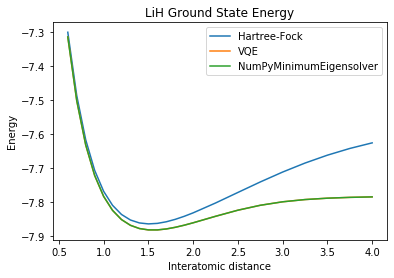

In [2]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right');

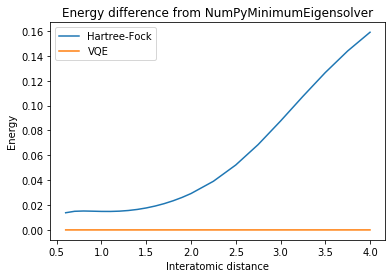

In [3]:
pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label='VQE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from NumPyMinimumEigensolver')
pylab.legend(loc='upper left');

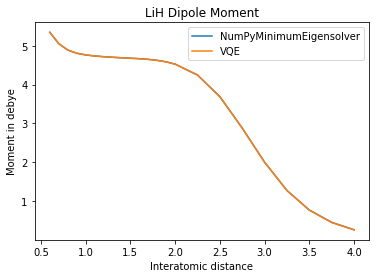

In [4]:
for j in reversed(range(len(algorithms))):
    pylab.plot(distances, dipoles[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Moment in debye')
pylab.title('LiH Dipole Moment')
pylab.legend(loc='upper right');

## _*LiH dissociation curve using NumPyMinimumEigensolver*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy and dipole moments of a Lithium Hydride (LiH) molecule over a range of inter-atomic distances.

This notebook has been written to use the PYSCF chemistry driver. 

In [1]:
import numpy as np
import pylab
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

In [2]:
# Note: In order to allow this to run reasonably quickly it takes advantage
#       of the ability to freeze core orbitals and remove unoccupied virtual
#       orbitals to reduce the size of the problem.

# tested molecular, LiH
molecule = 'Li .0 .0 -{0}; H .0 .0 {0}'

In [3]:
# choose 'NumPyMinimumEigensolver' or 'VQE' for experiments
algorithm = 'NumPyMinimumEigensolver'

In [4]:
# configure distance between two atoms
pts  = [x * 0.1  for x in range(6, 20)]
pts += [x * 0.25 for x in range(8, 16)]
pts += [4.0]
distances   = np.empty(len(pts))
hf_energies = np.empty(len(pts))
energies    = np.empty(len(pts))
dipoles     = np.empty(len(pts))

print('Processing step __', end='')
for i, d in enumerate(pts):
    print('\b\b{:2d}'.format(i), end='', flush=True) 
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule = driver.run()
    operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY, two_qubit_reduction=True,
                            freeze_core=True, orbital_reduction=[-3, -2])
    qubit_op, aux_ops = operator.run(qmolecule)
    if algorithm == 'NumPyMinimumEigensolver':
        result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
    else:
        optimizer = COBYLA(maxiter=20000)
        var_form = TwoLocal(qubit_op.num_qubits, ['ry', 'rz'], 'cz', reps=10)
        algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
        result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    
    result = operator.process_algorithm_result(result)
    distances[i] = d
    hf_energies[i] = result.hartree_fock_energy
    energies[i] = result.energy
    dipoles[i]  = result.total_dipole_moment / 0.393430307
print(' --- complete')

print('Distances: ', distances)
print('HF Energies:', hf_energies)
print('Energies:', energies)
print('Dipole moments:', dipoles)

Processing step 22 --- complete
Distances:  [0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.  ]
HF Energies: [-7.29954105 -7.48594487 -7.61577016 -7.70575334 -7.76736214 -7.80874318
 -7.83561583 -7.85195386 -7.86053866 -7.86335762 -7.86186477 -7.85714496
 -7.8500187  -7.84111204 -7.83090558 -7.80193896 -7.77087367 -7.74000074
 -7.7108299  -7.68437642 -7.6612016  -7.64145387 -7.62497563]
Energies: [-7.31334583 -7.50092209 -7.63097825 -7.72081241 -7.7822424  -7.82359928
 -7.85069838 -7.86756329 -7.87700149 -7.88101572 -7.88107204 -7.87826817
 -7.87344029 -7.86723396 -7.86015321 -7.84104271 -7.82307664 -7.8086124
 -7.79836343 -7.79175325 -7.78771697 -7.78531972 -7.78391847]
Dipole moments: [5.3479565  5.05436846 4.89154649 4.80824206 4.76423166 4.73775921
 4.71893511 4.70394304 4.69125691 4.67959192 4.66694467 4.65022445
 4.62517401 4.5864183  4.52758314 4.24518851 3.69244462 2.8795465
 1.99991673 1.27228084 0.76878114 0.451

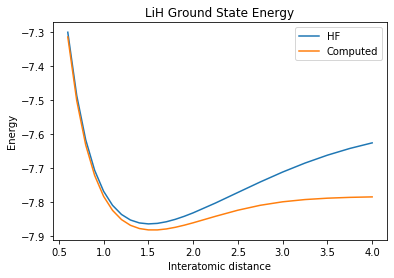

In [5]:
pylab.plot(distances, hf_energies, label='HF')
pylab.plot(distances, energies, label='Computed')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right');

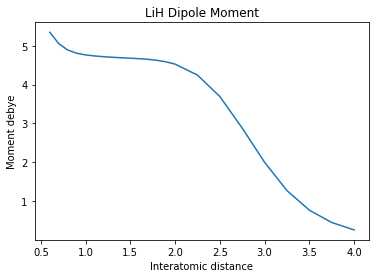

In [6]:
pylab.plot(distances, dipoles)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Moment debye')
pylab.title('LiH Dipole Moment');

## _*H2O ground state computation*_

This notebook demonstrates how to use Qiskit Chemistry to compute the ground state energy of a water (H2O) molecule using VQE and UCCSD.

While the molecule has been input below to the driver in xyz format, the Z-matrix format is also support. H2O in Z-matrix format would look like this 
```
H; O 1 1.08; H 2 1.08 1 104.5
```
and is convenient when the goal is to change bond angle, or plot the energy changing distance(s) while preserving the angle.

This notebook has been written to use the PYSCF chemistry driver. 

In [1]:
from qiskit import BasicAer

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SLSQP

from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType 
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

In [2]:
driver = PySCFDriver(atom='O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0',
                     unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print('Hartree-Fock energy: {}'.format(molecule.hf_energy))
print('Nuclear repulsion energy: {}'.format(molecule.nuclear_repulsion_energy))
print('Number of molecular orbitals: {}'.format(molecule.num_orbitals))
print('Number of alpha electrons: {}'.format(molecule.num_alpha))
print('Number of beta electrons: {}'.format(molecule.num_beta))

Hartree-Fock energy: -74.9629466565383
Nuclear repulsion energy: 9.193913160623385
Number of molecular orbitals: 7
Number of alpha electrons: 5
Number of beta electrons: 5


In [3]:
core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                   two_qubit_reduction=True, freeze_core=True)
qubit_op, aux_ops = core.run(molecule)

print(qubit_op)

Electronic Hamiltonian: Representation: paulis, qubits: 10, size: 551


In [4]:
ee = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops)
algo_result = ee.run()
result = core.process_algorithm_result(algo_result)
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.206272446428
  - computed part:      -23.544497240436
  - frozen energy part: -60.661775205992
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 9.193913160623
> Total ground state energy (Hartree): -75.012359285805
  Measured:: # Particles: 8.000 S: 0.000 S^2: 0.000 M: 0.00000
 
=== DIPOLE MOMENT ===
 
* Electronic dipole moment (a.u.): [0.0  1.57867263  0.0]
  - computed part:      [0.0  1.57778798  0.0]
  - frozen energy part: [0.0  0.00088465  0.0]
  - particle hole part: [0.0  0.0  0.0]
~ Nuclear dipole moment (a.u.): [0.0  2.21475902  0.0]
> Dipole moment (a.u.): [0.0  0.63608639  0.0]  Total: 0.63608639
               (debye): [0.0  1.61677018  0.0]  Total: 1.61677018


In [5]:
init_state = HartreeFock(num_orbitals=core._molecule_info['num_orbitals'],
                         num_particles=core._molecule_info['num_particles'],
                         qubit_mapping=core._qubit_mapping,
                         two_qubit_reduction=core._two_qubit_reduction)

var_form = UCCSD(num_orbitals=core._molecule_info['num_orbitals'], 
                 num_particles=core._molecule_info['num_particles'],
                 qubit_mapping=core._qubit_mapping,
                 two_qubit_reduction=core._two_qubit_reduction, 
                 initial_state=init_state)

optimizer = SLSQP(maxiter=2500)

# setup backend on which we will run
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend)

vqe = VQE(qubit_op, var_form, optimizer)
algo_result = vqe.run(quantum_instance)
result = core.process_algorithm_result(algo_result)

print('Ground state energy: {}'.format(result.energy))
print(result)
print('Actual VQE evaluations taken: {}'.format(algo_result.optimizer_evals))

Ground state energy: -75.01225859234138
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.206171752965
  - computed part:      -23.544396546972
  - frozen energy part: -60.661775205992
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 9.193913160623
> Total ground state energy (Hartree): -75.012258592341
Actual VQE evaluations taken: 666


In [6]:
import numpy as np
import pylab

h2o = 'H; O 1 1.08; H 2 {} 1 104.5'

distances = [x * 0.01 + 1.00 for x in range(17)]
energies = np.empty(len(distances))

for i, distance in enumerate(distances):
    driver = PySCFDriver(h2o.format(distance), basis='sto3g')
    qmolecule = driver.run()
    operator =  Hamiltonian(freeze_core=True)
    qubit_op, aux_ops = operator.run(qmolecule)
    result = NumPyMinimumEigensolver(qubit_op).run()
    result = operator.process_algorithm_result(result)
    energies[i] = result.energy

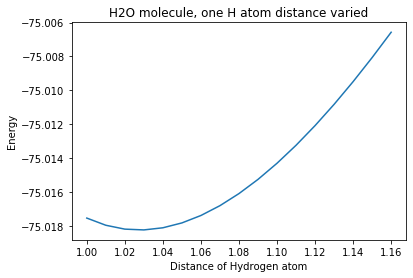

In [7]:
pylab.plot(distances, energies)
pylab.xlabel('Distance of Hydrogen atom')
pylab.ylabel('Energy')
pylab.title('H2O molecule, one H atom distance varied');

## _*H2 ground state energy computation using Iterative QPE*_



In [1]:
import pylab
import time
import numpy as np
import multiprocessing as mp
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance, AquaError
from qiskit.aqua.operators import Z2Symmetries, op_converter
from qiskit.aqua.algorithms import IQPE, NumPyMinimumEigensolver
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

def compute_energy(i, distance, algorithm):
    try:
        driver = PySCFDriver(
            atom='H .0 .0 .0; H .0 .0 {}'.format(distance),
            unit=UnitsType.ANGSTROM,
            charge=0,
            spin=0,
            basis='sto3g'
        )
    except:
        raise AquaError('PYSCF driver does not appear to be installed')
    molecule = driver.run()
    qubit_mapping = 'parity'
    fer_op = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubit_op = Z2Symmetries.two_qubit_reduction(
        op_converter.to_weighted_pauli_operator(fer_op.mapping(map_type=qubit_mapping, threshold=1e-10)), 2)

    if algorithm == 'NumPyMinimumEigensolver':
        eigensolver = NumPyMinimumEigensolver(qubit_op)
        result = eigensolver.run()
        reference_energy = result.eigenvalue.real
    elif algorithm == 'IQPE':
        num_particles = molecule.num_alpha + molecule.num_beta
        two_qubit_reduction = True
        num_orbitals = qubit_op.num_qubits + (2 if two_qubit_reduction else 0)

        num_time_slices = 1
        num_iterations = 12
        state_in = HartreeFock(num_orbitals,
                               num_particles, qubit_mapping, two_qubit_reduction)
        iqpe = IQPE(qubit_op, state_in, num_time_slices, num_iterations,
                    expansion_mode='trotter', expansion_order=1,
                    shallow_circuit_concat=True)
        backend = BasicAer.get_backend('statevector_simulator')
        quantum_instance = QuantumInstance(backend)

        result = iqpe.run(quantum_instance)
    else:
        raise AquaError('Unrecognized algorithm: {}'.format(algorithm))
    return i, distance, result.eigenvalue.real + molecule.nuclear_repulsion_energy, molecule.hf_energy

In [2]:
import concurrent.futures
import multiprocessing as mp

algorithms = ['IQPE', 'NumPyMinimumEigensolver']
start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

start_time = time.time()
max_workers = max(4, mp.cpu_count())
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for j in range(len(algorithms)):
        algorithm = algorithms[j]
        for i in range(steps+1):
            d = start + i*by/steps
            future = executor.submit(
                compute_energy, 
                i, 
                d, 
                algorithm
            )
            futures.append(future)
        for future in concurrent.futures.as_completed(futures):
            i, d, energy, hf_energy = future.result()
            energies[j][i] = energy
            hf_energies[i] = hf_energy
            distances[i] = d
        
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)

print("--- %s seconds ---" % (time.time() - start_time))

 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[-1.04301318 -1.06320142 -1.08046604 -1.09428928 -1.10410788 -1.11248618
  -1.11870203 -1.12203285 -1.12480205 -1.12619329 -1.12540821 -1.12460086
  -1.12291101 -1.12045975 -1.11735113 -1.11367463 -1.10950729 -1.10491566
  -1.10086038 -1.095576   -1.09090328]
 [-1.05515979 -1.07591366 -1.09262991 -1.10591805 -1.11628601 -1.12416092
  -1.12990478 -1.13382622 -1.13618945 -1.13722138 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836188 -1.12467175 -1.12056028 -1.11609624
  -1.11133942 -1.10634211 -1.10115033]]
Hartree-Fock energies: [-1.04299627 -1.06306214 -1.07905074 -1.0915705  -1.10112824 -1.10814999
 -1.11299655 -1.11597526 -1.11734903 -1.11734327 -1.11615145 -1.11393966
 -1.1108504  -1.10700581 -1.10251055 -1.09745432 -1.09191404 -1.08595587
 -1.07963693 -1.07300676 -1.06610865]
--- 186.6669979095459 seconds --

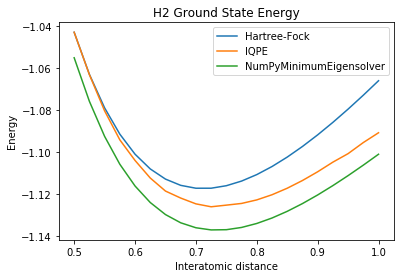

In [3]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right')
pylab.show()

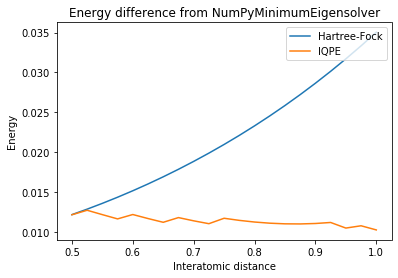

In [4]:
pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label='IQPE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from NumPyMinimumEigensolver')
pylab.legend(loc='upper right')
pylab.show()

# Measurement Optimization

In [1]:
import functools
from pennylane import numpy as np
import pennylane as qml

np.random.seed(42)

symbols, coordinates = qml.qchem.read_structure("h2.xyz")
H, num_qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

print("Required number of qubits:", num_qubits)
print(H)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Required number of qubits: 4
  (-0.24274280046579544) [Z2]
+ (-0.24274280046579544) [Z3]
+ (-0.04207898539372534) [I0]
+ (0.177712875026871) [Z1]
+ (0.17771287502687114) [Z0]
+ (0.12293305045313234) [Z0 Z2]
+ (0.12293305045313234) [Z1 Z3]
+ (0.16768319431884043) [Z0 Z3]
+ (0.16768319431884043) [Z1 Z2]
+ (0.1705973836507591) [Z0 Z1]
+ (0.17627640722401217) [Z2 Z3]
+ (-0.0447501438657081) [Y0 Y1 X2 X3]
+ (-0.0447501438657081) [X0 X1 Y2 Y3]
+ (0.0447501438657081) [Y0 X1 X2 Y3]
+ (0.0447501438657081) [X0 Y1 Y2 X3]


In [2]:
# Create a 4 qubit simulator
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

# number of electrons
electrons = 2

# Define the Hartree-Fock initial state for our variational circuit
initial_state = qml.qchem.hf_state(electrons, num_qubits)

# Construct the UCCSD ansatz
singles, doubles = qml.qchem.excitations(electrons, num_qubits)
s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)
ansatz = functools.partial(
    qml.UCCSD, init_state=initial_state, s_wires=s_wires, d_wires=d_wires
)

# generate the cost function
@qml.qnode(dev)
def cost_circuit(params):
    ansatz(params, wires=dev.wires)
    return qml.expval(H)

In [3]:
params = np.random.normal(0, np.pi, len(singles) + len(doubles))
with qml.Tracker(dev) as tracker:  # track the number of executions
    print("Cost function value:", cost_circuit(params))

print("Number of quantum evaluations:", tracker.totals['executions'])

Cost function value: -0.5657291586837982
Number of quantum evaluations: 15


In [5]:
symbols, coordinates = qml.qchem.read_structure("h2o.xyz")
H, num_qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

print("Required number of qubits:", num_qubits)
print("Number of Hamiltonian terms/required measurements:", len(H.ops))

print("\n", H)

Required number of qubits: 14
Number of Hamiltonian terms/required measurements: 2110

   (-46.4639069134152) [I0]
+ (0.782965207048723) [Z11]
+ (0.7829652070487234) [Z10]
+ (0.8084591005184665) [Z12]
+ (0.8084591005184665) [Z13]
+ (1.2034393391308014) [Z4]
+ (1.2034393391308018) [Z5]
+ (1.3096876618626825) [Z7]
+ (1.309687661862683) [Z6]
+ (1.3693525711702457) [Z8]
+ (1.3693525711702463) [Z9]
+ (1.6538938305466937) [Z2]
+ (1.6538938305466937) [Z3]
+ (12.412630714439185) [Z0]
+ (12.412630714439185) [Z1]
+ (-7.954224802993182e-06) [Y11 Y13]
+ (-7.954224802993182e-06) [X11 X13]
+ (-1.6021751089569596e-06) [Y2 Y4]
+ (-1.6021751089569596e-06) [X2 X4]
+ (5.92928064922435e-07) [Y4 Y6]
+ (5.92928064922435e-07) [X4 X6]
+ (7.765082199464538e-07) [Y3 Y5]
+ (7.765082199464538e-07) [X3 X5]
+ (1.8540565460492282e-06) [Y5 Y7]
+ (1.8540565460492282e-06) [X5 X7]
+ (8.194105026788912e-06) [Y10 Y12]
+ (8.194105026788912e-06) [X10 X12]
+ (0.00327696506575944) [Y1 Y3]
+ (0.00327696506575944) [X1 X3]
+ (0.

In [21]:
obs = [
    qml.PauliX(0) @ qml.PauliY(1),
    qml.PauliX(0) @ qml.PauliZ(2)
]

In [22]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def circuit1(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(3))
    return qml.expval(obs[0])


@qml.qnode(dev)
def circuit2(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(3))
    return qml.expval(obs[1])

param_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=3, n_wires=3)
weights = np.random.normal(scale=0.1, size=param_shape)

print("Expectation value of XYI = ", circuit1(weights))
print("Expectation value of XIZ = ", circuit2(weights))

Expectation value of XYI =  0.024006083117347365
Expectation value of XIZ =  0.054380142806719683


In [23]:
@qml.qnode(dev)
def circuit_qwc(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(3))

    # rotate wire 0 into the shared eigenbasis
    qml.RY(-np.pi / 2, wires=0)

    # rotate wire 1 into the shared eigenbasis
    qml.RX(np.pi / 2, wires=1)

    # wire 2 does not require a rotation

    # measure probabilities in the computational basis
    return qml.probs(wires=range(3))


rotated_probs = circuit_qwc(weights)
print(rotated_probs)

[0.25951834 0.00303245 0.26246142 0.00066657 0.22284399 0.00202498
 0.24626692 0.00318533]


In [24]:
eigenvalues_XYI = np.kron(np.kron([1, -1], [1, -1]), [1, 1])
eigenvalues_XIZ = np.kron(np.kron([1, -1], [1, 1]), [1, -1])

# Taking the linear combination of the eigenvalues and the probabilities
print("Expectation value of XYI = ", np.dot(eigenvalues_XYI, rotated_probs))
print("Expectation value of XIZ = ", np.dot(eigenvalues_XIZ, rotated_probs))

Expectation value of XYI =  0.024006083117347435
Expectation value of XIZ =  0.054380142806719836


In [25]:
@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(3))
    return [
        qml.expval(qml.PauliX(0) @ qml.PauliY(1)),
        qml.expval(qml.PauliX(0) @ qml.PauliZ(2))
    ]


print(circuit(weights))

[0.02400608 0.05438014]


In [26]:
rotations, new_obs = qml.grouping.diagonalize_qwc_pauli_words(obs)

print(rotations)
print(new_obs)

[RY(-1.5707963267948966, wires=[0]), RX(1.5707963267948966, wires=[1])]
[PauliZ(wires=[0]) @ PauliZ(wires=[1]), PauliZ(wires=[0]) @ PauliZ(wires=[2])]


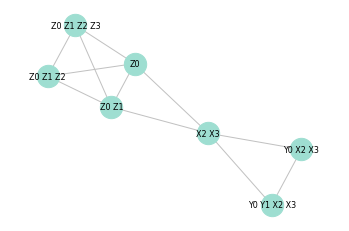

In [27]:
import networkx as nx
from matplotlib import pyplot as plt

terms = [
    qml.PauliZ(0),
    qml.PauliZ(0) @ qml.PauliZ(1),
    qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2),
    qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3),
    qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliY(0) @ qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliY(0) @ qml.PauliY(1) @ qml.PauliX(2) @ qml.PauliX(3)
]

G = nx.Graph()

# add the terms to the graph
G.add_nodes_from(terms)

# add QWC edges
G.add_edges_from([
    [terms[0], terms[1]],  # Z0 <--> Z0 Z1
    [terms[0], terms[2]],  # Z0 <--> Z0 Z1 Z2
    [terms[0], terms[3]],  # Z0 <--> Z0 Z1 Z2 Z3
    [terms[1], terms[2]],  # Z0 Z1 <--> Z0 Z1 Z2
    [terms[2], terms[3]],  # Z0 Z1 Z2 <--> Z0 Z1 Z2 Z3
    [terms[1], terms[3]],  # Z0 Z1 <--> Z0 Z1 Z2 Z3
    [terms[0], terms[4]],  # Z0 <--> X2 X3
    [terms[1], terms[4]],  # Z0 Z1 <--> X2 X3
    [terms[4], terms[5]],  # X2 X3 <--> Y0 X2 X3
    [terms[4], terms[6]],  # X2 X3 <--> Y0 Y1 X2 X3
    [terms[5], terms[6]],  # Y0 X2 X3 <--> Y0 Y1 X2 X3
])


def format_pauli_word(term):
    """Convenience function that nicely formats a PennyLane
    tensor observable as a Pauli word"""
    if isinstance(term, qml.operation.Tensor):
        return " ".join([format_pauli_word(t) for t in term.obs])

    return f"{term.name[-1]}{term.wires.tolist()[0]}"

plt.margins(x=0.1)
nx.draw(
    G,
    labels={node: format_pauli_word(node) for node in terms},
    with_labels=True,
    node_size=500,
    font_size=8,
    node_color="#9eded1",
    edge_color="#c1c1c1"
)

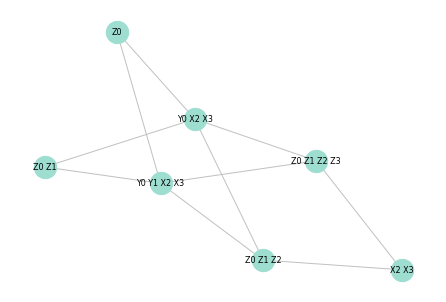

In [28]:
C = nx.complement(G)
coords = nx.spring_layout(C)

nx.draw(
    C,
    coords,
    labels={node: format_pauli_word(node) for node in terms},
    with_labels=True,
    node_size=500,
    font_size=8,
    node_color="#9eded1",
    edge_color="#c1c1c1"
)

Minimum number of QWC groupings found: 2

Group 0:
Y0 X2 X3
Y0 Y1 X2 X3
X2 X3

Group 1:
Z0 Z1 Z2
Z0 Z1 Z2 Z3
Z0
Z0 Z1


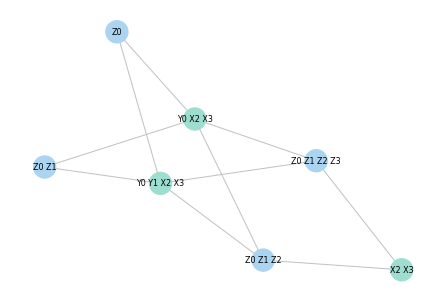

In [29]:
groups = nx.coloring.greedy_color(C, strategy="largest_first")

# plot the complement graph with the greedy colouring
nx.draw(
    C,
    coords,
    labels={node: format_pauli_word(node) for node in terms},
    with_labels=True,
    node_size=500,
    font_size=8,
    node_color=[("#9eded1", "#aad4f0")[groups[node]] for node in C],
    edge_color="#c1c1c1"
)


num_groups = len(set(groups.values()))
print("Minimum number of QWC groupings found:", num_groups)


for i in range(num_groups):
    print(f"\nGroup {i}:")

    for term, group_id in groups.items():
        if group_id == i:
            print(format_pauli_word(term))

In [30]:
obs_groupings = qml.grouping.group_observables(terms, grouping_type='qwc', method='rlf')

In [31]:
rotations, measurements = qml.grouping.diagonalize_qwc_groupings(obs_groupings)

In [32]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def circuit(weights, group=None, **kwargs):
    qml.StronglyEntanglingLayers(weights, wires=range(4))
    return [qml.expval(o) for o in group]

param_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=3, n_wires=4)
weights = np.random.normal(scale=0.1, size=param_shape)
result = [circuit(weights, group=g) for g in obs_groupings]

print("Term expectation values:")
for group, expvals in enumerate(result):
    print(f"Group {group} expectation values:", expvals)

# Since all the coefficients of the Hamiltonian are unity,
# we can simply sum the expectation values.
print("<H> = ", np.sum(np.hstack(result)))

Term expectation values:
Group 0 expectation values: [-0.02327454 -0.0331662  -0.00460786]
Group 1 expectation values: [0.95135313 0.97538172 0.99090168 0.977942  ]
<H> =  3.834529924448169


In [33]:
H = qml.Hamiltonian(coeffs=np.ones(len(terms)), observables=terms, grouping_type="qwc")
@qml.qnode(dev)
def cost_fn(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(4))
    return qml.expval(H)
print(cost_fn(weights))

3.834529924448169


In [6]:
obs = [
    qml.PauliX(0) @ qml.PauliY(1),
    qml.PauliX(0) @ qml.PauliZ(2)
]

In [7]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def circuit1(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(3))
    return qml.expval(obs[0])


@qml.qnode(dev)
def circuit2(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(3))
    return qml.expval(obs[1])

param_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=3, n_wires=3)
weights = np.random.normal(scale=0.1, size=param_shape)

print("Expectation value of XYI = ", circuit1(weights))
print("Expectation value of XIZ = ", circuit2(weights))

Expectation value of XYI =  0.04330349736163838
Expectation value of XIZ =  -0.014466813606153896


Now, let\'s use our QWC approach to reduce this down to a *single*
measurement of the probabilities in the shared eigenbasis of both QWC
observables:


In [8]:
@qml.qnode(dev)
def circuit_qwc(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(3))

    # rotate wire 0 into the shared eigenbasis
    qml.RY(-np.pi / 2, wires=0)

    # rotate wire 1 into the shared eigenbasis
    qml.RX(np.pi / 2, wires=1)

    # wire 2 does not require a rotation

    # measure probabilities in the computational basis
    return qml.probs(wires=range(3))


rotated_probs = circuit_qwc(weights)
print(rotated_probs)

[0.25067393 0.00195986 0.23037242 0.00149689 0.23943888 0.00704006
 0.26433778 0.00468018]


In [9]:
eigenvalues_XYI = np.kron(np.kron([1, -1], [1, -1]), [1, 1])
eigenvalues_XIZ = np.kron(np.kron([1, -1], [1, 1]), [1, -1])

# Taking the linear combination of the eigenvalues and the probabilities
print("Expectation value of XYI = ", np.dot(eigenvalues_XYI, rotated_probs))
print("Expectation value of XIZ = ", np.dot(eigenvalues_XIZ, rotated_probs))

Expectation value of XYI =  0.04330349736163838
Expectation value of XIZ =  -0.014466813606153733


Compare this to the result when we used two circuit evaluations. We have
successfully used a single circuit evaluation to recover both
expectation values!

Luckily, PennyLane automatically performs this QWC grouping under the
hood. We simply return the two QWC Pauli terms from the QNode:


In [10]:
@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(3))
    return [
        qml.expval(qml.PauliX(0) @ qml.PauliY(1)),
        qml.expval(qml.PauliX(0) @ qml.PauliZ(2))
    ]


print(circuit(weights))

[ 0.0433035  -0.01446681]


In [11]:
rotations, new_obs = qml.grouping.diagonalize_qwc_pauli_words(obs)

print(rotations)
print(new_obs)

[RY(-1.5707963267948966, wires=[0]), RX(1.5707963267948966, wires=[1])]
[PauliZ(wires=[0]) @ PauliZ(wires=[1]), PauliZ(wires=[0]) @ PauliZ(wires=[2])]


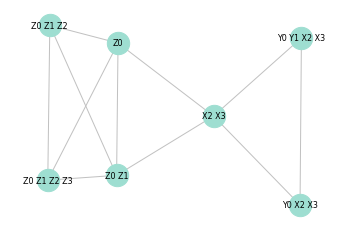

In [12]:
import networkx as nx
from matplotlib import pyplot as plt

terms = [
    qml.PauliZ(0),
    qml.PauliZ(0) @ qml.PauliZ(1),
    qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2),
    qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3),
    qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliY(0) @ qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliY(0) @ qml.PauliY(1) @ qml.PauliX(2) @ qml.PauliX(3)
]

G = nx.Graph()

# add the terms to the graph
G.add_nodes_from(terms)

# add QWC edges
G.add_edges_from([
    [terms[0], terms[1]],  # Z0 <--> Z0 Z1
    [terms[0], terms[2]],  # Z0 <--> Z0 Z1 Z2
    [terms[0], terms[3]],  # Z0 <--> Z0 Z1 Z2 Z3
    [terms[1], terms[2]],  # Z0 Z1 <--> Z0 Z1 Z2
    [terms[2], terms[3]],  # Z0 Z1 Z2 <--> Z0 Z1 Z2 Z3
    [terms[1], terms[3]],  # Z0 Z1 <--> Z0 Z1 Z2 Z3
    [terms[0], terms[4]],  # Z0 <--> X2 X3
    [terms[1], terms[4]],  # Z0 Z1 <--> X2 X3
    [terms[4], terms[5]],  # X2 X3 <--> Y0 X2 X3
    [terms[4], terms[6]],  # X2 X3 <--> Y0 Y1 X2 X3
    [terms[5], terms[6]],  # Y0 X2 X3 <--> Y0 Y1 X2 X3
])


def format_pauli_word(term):
    """Convenience function that nicely formats a PennyLane
    tensor observable as a Pauli word"""
    if isinstance(term, qml.operation.Tensor):
        return " ".join([format_pauli_word(t) for t in term.obs])

    return f"{term.name[-1]}{term.wires.tolist()[0]}"

plt.margins(x=0.1)
nx.draw(
    G,
    labels={node: format_pauli_word(node) for node in terms},
    with_labels=True,
    node_size=500,
    font_size=8,
    node_color="#9eded1",
    edge_color="#c1c1c1"
)

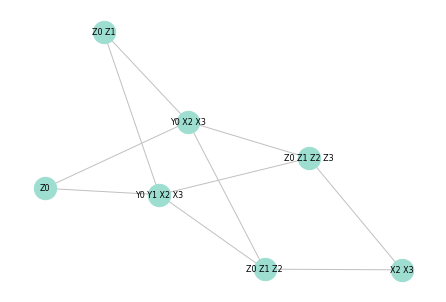

In [13]:
C = nx.complement(G)
coords = nx.spring_layout(C)

nx.draw(
    C,
    coords,
    labels={node: format_pauli_word(node) for node in terms},
    with_labels=True,
    node_size=500,
    font_size=8,
    node_color="#9eded1",
    edge_color="#c1c1c1"
)

Now that we have the complement graph, we can perform a greedy coloring
to determine the minimum number of QWC groups:


Minimum number of QWC groupings found: 2

Group 0:
Y0 X2 X3
Y0 Y1 X2 X3
X2 X3

Group 1:
Z0 Z1 Z2
Z0 Z1 Z2 Z3
Z0
Z0 Z1


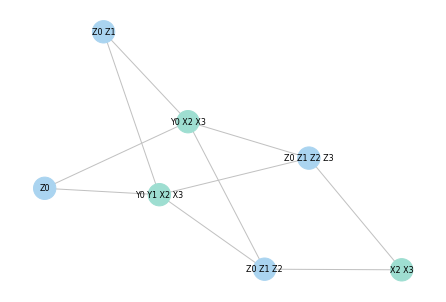

In [14]:
groups = nx.coloring.greedy_color(C, strategy="largest_first")

# plot the complement graph with the greedy colouring
nx.draw(
    C,
    coords,
    labels={node: format_pauli_word(node) for node in terms},
    with_labels=True,
    node_size=500,
    font_size=8,
    node_color=[("#9eded1", "#aad4f0")[groups[node]] for node in C],
    edge_color="#c1c1c1"
)


num_groups = len(set(groups.values()))
print("Minimum number of QWC groupings found:", num_groups)


for i in range(num_groups):
    print(f"\nGroup {i}:")

    for term, group_id in groups.items():
        if group_id == i:
            print(format_pauli_word(term))

In [15]:
obs_groupings = qml.grouping.group_observables(terms, grouping_type='qwc', method='rlf')

In [16]:
rotations, measurements = qml.grouping.diagonalize_qwc_groupings(obs_groupings)

In [17]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def circuit(weights, group=None, **kwargs):
    qml.StronglyEntanglingLayers(weights, wires=range(4))
    return [qml.expval(o) for o in group]

param_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=3, n_wires=4)
weights = np.random.normal(scale=0.1, size=param_shape)
result = [circuit(weights, group=g) for g in obs_groupings]

print("Term expectation values:")
for group, expvals in enumerate(result):
    print(f"Group {group} expectation values:", expvals)

# Since all the coefficients of the Hamiltonian are unity,
# we can simply sum the expectation values.
print("<H> = ", np.sum(np.hstack(result)))

Term expectation values:
Group 0 expectation values: [ 0.27492493  0.00402838 -0.0102099 ]
Group 1 expectation values: [0.99865999 0.98385723 0.95656064 0.98498103]
<H> =  4.192802303878931


In [18]:
H = qml.Hamiltonian(coeffs=np.ones(len(terms)), observables=terms, grouping_type="qwc")
@qml.qnode(dev)
def cost_fn(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(4))
    return qml.expval(H)
print(cost_fn(weights))



4.192802303878931


In [20]:
symbols, coordinates = qml.qchem.read_structure("h2o.xyz")
H, num_qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of Hamiltonian terms/required measurements:", len(H.ops))

# grouping
groups = qml.grouping.group_observables(H.ops, grouping_type='qwc', method='rlf')
print("Number of required measurements after optimization:", len(groups))

Number of Hamiltonian terms/required measurements: 2110
Number of required measurements after optimization: 556


We went from 2110 required measurements evaluations to 556 (just
over *two thousand* down to *five hundred* !!, we successfully make it 4 times more efficient ).

This problem of measurement optimization no longer just applies to the VQE algorithm (the algorithm it was born
from). Instead, there are a multitude of algorithms that could benefit
from these measurement optimization techniques (QAOA being a prime
example).

